****
# Import modules
****

In [1]:
import os
import pandas as pd
import numpy as np

import statsmodels.formula.api as smf

****
# Load Data
****

In [6]:
file_path = "C:\\Users\\kruu\\store\\data_EDDM\\"

filenames = next(os.walk(file_path), (None, None, []))[2]

data_EDDM = pd.read_parquet(os.path.join(file_path +filenames[0]))

for path in filenames[1:]:
    temp = pd.read_parquet(os.path.join(file_path + path))
    data_EDDM = pd.concat((data_EDDM, temp))

In [7]:
#Check any missing data
data_EDDM[["avg_wind_dir", "avg_wind_speed", "avg_vis", "avg_temp", "avg_press"]].isna().any()

avg_wind_dir       True
avg_wind_speed    False
avg_vis           False
avg_temp          False
avg_press         False
dtype: bool

****
# LR Model
****

In [ ]:
model_lm = smf.ols(
    "nominal_distance_prop ~ C(star) + C(weekday) + avg_vis + avg_wind_speed + C(season) + avg_vis + avg_press + C(body_type, Treatment(reference='Narrowbody')) + C(rush_hour) + avg_temp", 
    data_EDDM, 
)

res_lm = model_lm.fit()
res_lm.summary()

****
# Plots
****

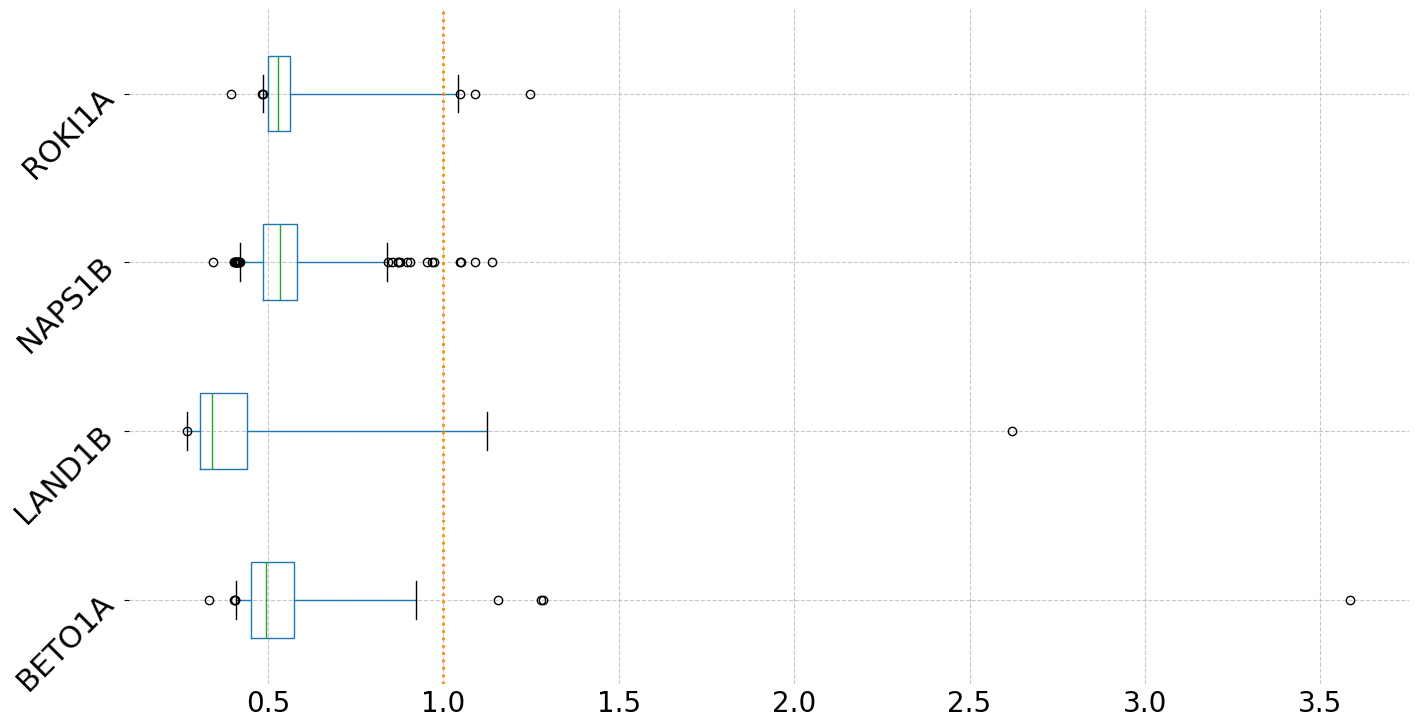

In [8]:
boxplot = data_EDDM.boxplot(["nominal_distance_prop"], by = ["star"],
                     figsize = (16, 9),
                     vert = False,
                     showmeans = False,
                     notch = False,
                     whis = (2.5,97.5))

boxplot.axvline(x=1, color='darkorange', linestyle=':', linewidth=2)

custom_labels = ['BETO1A', 'LAND1B', 'NAPS1B', 'ROKI1A'] #MAYBE IN WRONG ORDER
boxplot.set_yticklabels(custom_labels, fontsize=22, rotation=45)

boxplot.get_figure().suptitle('')
boxplot.set_ylabel("")
boxplot.set_title('')

boxplot.set_axisbelow(True)
boxplot.grid(True, linestyle='--', alpha=0.7)
boxplot.spines['top'].set_visible(False)
boxplot.spines['right'].set_visible(False)
boxplot.spines['left'].set_visible(False)
boxplot.spines['bottom'].set_visible(False)
boxplot.tick_params(axis='x', which='both', length=0, labelsize=20)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

coefficients = res_lm.params
p_values = res_lm.pvalues

# features = coefficients.index  # Feature names
features = np.array([ #Same order as coefficients.index 
    "Intercept", 
    "STAR: LAND1B",
    "STAR: NAPS1B",
    "STAR: ROKIT1A",
    "WEEKDAY: Tuesday",
    "WEEKDAY: Wednesday",
    "WEEKDAY: Thursday",
    "WEEKDAY: Friday",
    "WEEKDAY: Saturday",
    "WEEKDAY: Sunday",
    "SEASON: Spring",
    "SEASON: Summer",
    "SEASON: Winter",
    "BODY TYPE: Regional jet",
    "RUSH HOUR: True",
    "Visibility",
    "Wind speed",
    "Pressure",
    "Temperature",
])
importance = coefficients.values  # Absolute coefficients to represent feature importance

indices = np.argsort(importance)

bar_color = 'steelblue'

def significance_stars(p_value):
    if p_value <= 0.01:
        return '***'
    elif p_value <= 0.05:
        return '**'
    elif p_value <= 0.10:
        return '*'
    else:
        return ''

plt.figure(figsize=(12, 8))
plt.barh(range(len(importance)), importance[indices], align='center', color=bar_color)

# Add significance stars and values
for i in range(len(importance)):
    pvalue = significance_stars(p_values[indices][i])
    if p_values[indices][i] < 0.05: 
        if importance[indices][i] > 0:
            plt.text(importance[indices][i] * 1.01, i, f'{np.round(importance[indices][i],3)}{pvalue}', va='center', fontsize=14)
        else:
            plt.text(0.001, i, f'{np.round(importance[indices][i],3)}{pvalue}', va='center', fontsize=14)
        
# Set y-ticks and color them based on significance
y_labels = plt.yticks(range(len(importance)), features[indices], fontsize=16)
for i in range(len(importance)):
    if p_values[indices][i] > 0.05:
        y_labels[1][i].set_color('firebrick')

# Center the zero point in the x-axis
ax = plt.gca()
ax.set_xlim(-0.3, 0.8)
ax.grid(True, axis='y', linestyle='--', alpha=0.7)
ax.set_axisbelow(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.tick_params(axis='y', which='both', length=0)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) 
plt.xlabel('')
plt.title('')
plt.tight_layout()
plt.show()
